In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/content/drive/MyDrive/ML/jena_climate_2009_2016.csv'
df = pd.read_csv(file_path)



In [ ]:
!pip install tensorflow==2.12


Analyzing the Jena weather dataset reveals it comprises 420,451 rows with 15 distinct features.

In [ ]:
import os
fname = os.path.join("/content/drive/MyDrive/ML/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Processing the data involves parsing the comma-separated values into floating-point numbers. Following this, certain values are extracted from the dataset and stored in arrays named temperature and raw_data for subsequent analysis or processing.

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries

Text(0, 0.5, 'Temperature')

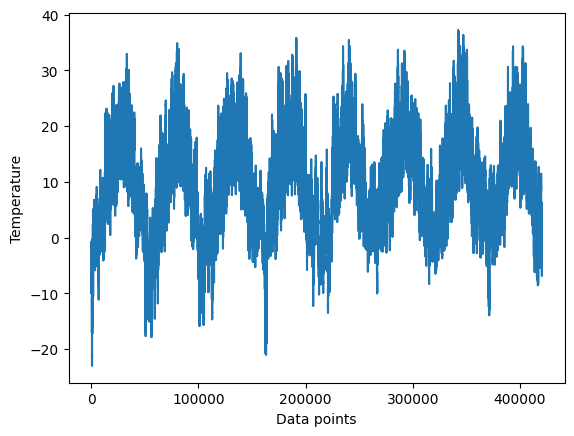

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Visualizing the temperature timeseries for the first 10 days entails plotting 1440 data points, considering that each day consists of 144 data points.

Text(0, 0.5, 'Temperature')

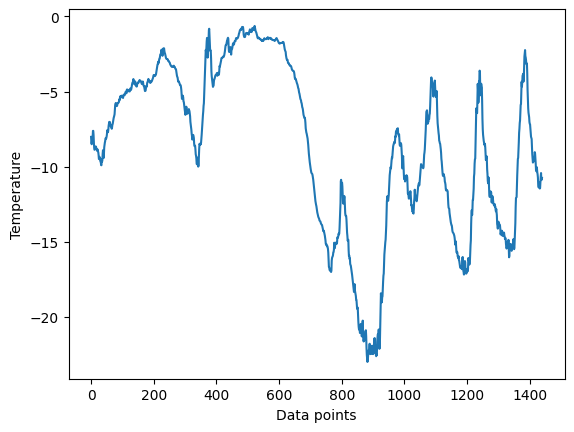

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Determining the sample distribution for data splitting involves allocating 50% of the samples for training and 25% for validation.

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Data Preparation:**
Data preparation involves normalization, where each variable is standardized to account for differing scales. While vectorization isn't required since the data is already in a numerical format, it's important to normalize the variables due to their varying ranges. For instance, temperature ranges from -20 to +30 while pressure is measured in millibars.

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating datasets for training, validation, and testing is necessary due to the high redundancy of samples in the dataset. Allocating memory for each sample explicitly would be inefficient. Therefore, we'll dynamically generate the samples to optimize memory usage.

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Examining the output of one of our datasets.

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Calculating the Mean Absolute Error (MAE) for a common-sense, non-machine-learning baseline. The function "evaluate_naive_method" serves as a benchmark for assessing the effectiveness of a straightforward forecasting method. In this method, the last value in the input sequence is predicted as the next value.

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Utilizing the common-sense baseline approach of predicting that the temperature in the next 24 hours will be identical to the current temperature, the test MAE is 2.62 degrees Celsius. Similarly, the validation MAE using this straightforward baseline method is 2.44 degrees Celsius. This implies that assuming the future temperature remains constant at the current temperature would result in an average deviation of around two and a half degrees.

**Developing *and assessing a basic machine-learning model consisting of densely connected layers **bold text**.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 42s 50ms/step - loss: 13.0759 - mae: 2.7946 - val_loss: 11.8183 - val_mae: 2.7187
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 9.2328 - mae: 2.3895 - val_loss: 10.4720 - val_mae: 2.5583
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.4486 - mae: 2.2882 - val_loss: 10.7883 - val_mae: 2.6038
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 8.0091 - mae: 2.2294 - val_loss: 10.6135 - val_mae: 2.5869
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 7.7149 - mae: 2.1884 - val_loss: 11.8487 - val_mae: 2.7203
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 7.4948 - mae: 2.1551 - val_loss: 11.7121 - val_mae: 2.7138
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 7.3006 - mae: 2.1306 - val_loss: 10.6684 - val_mae: 2.5859
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 32ms/step - loss: 11.7262 - mae: 2.6841
Test MAE: 2.68


**Plotting** **results**

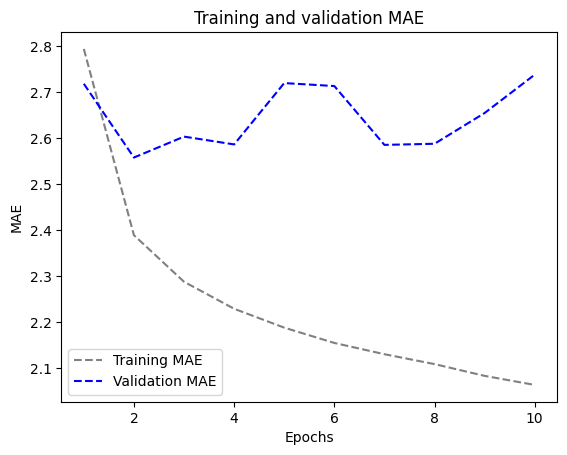

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Let's do 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 101ms/step - loss: 21.3967 - mae: 3.6170 - val_loss: 18.0795 - val_mae: 3.3795
Epoch 2/10
819/819 [==============================] - 83s 101ms/step - loss: 15.3018 - mae: 3.1084 - val_loss: 17.3485 - val_mae: 3.3182
Epoch 3/10
819/819 [==============================] - 85s 104ms/step - loss: 14.0794 - mae: 2.9759 - val_loss: 15.4014 - val_mae: 3.1219
Epoch 4/10
819/819 [==============================] - 80s 98ms/step - loss: 13.3178 - mae: 2.8899 - val_loss: 15.3561 - val_mae: 3.0815
Epoch 5/10
819/819 [==============================] - 81s 99ms/step - loss: 12.6952 - mae: 2.8215 - val_loss: 14.2288 - val_mae: 2.9742
Epoch 6/10
819/819 [==============================] - 84s 103ms/step - loss: 12.1761 - mae: 2.7597 - val_loss: 14.1368 - val_mae: 2.9746
Epoch 7/10
819/819 [==============================] - 84s 102ms/step - loss: 11.6691 - mae: 2.7022 - val_loss: 17.3094 - val_mae: 3.2575
Epoch 8/10
819/819 [=======================

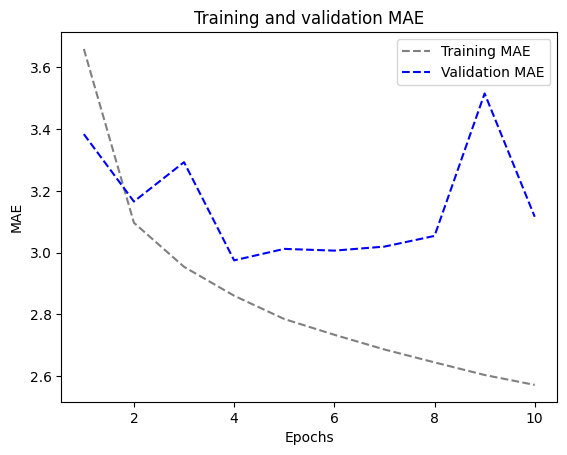

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seems that the convolutional data performed poor compared to common sense or dense model. This could be because*

- The assumption of translation invariance does not hold well for weather data.

-* The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order. *

**A Simple RNN**

1.An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 112s 130ms/step - loss: 138.5534 - mae: 9.6915 - val_loss: 144.0246 - val_mae: 9.9059
Epoch 2/10
819/819 [==============================] - 83s 101ms/step - loss: 136.3835 - mae: 9.5589 - val_loss: 143.7635 - val_mae: 9.8769
Epoch 3/10
819/819 [==============================] - 101s 123ms/step - loss: 136.2832 - mae: 9.5509 - val_loss: 143.7611 - val_mae: 9.8705
Epoch 4/10
819/819 [==============================] - 80s 97ms/step - loss: 136.3759 - mae: 9.5573 - val_loss: 143.7285 - val_mae: 9.8752
Epoch 5/10
819/819 [==============================] - 103s 125ms/step - loss: 136.3494 - mae: 9.5571 - val_loss: 143.7493 - val_mae: 9.8798
Epoch 6/10
819/819 [==============================] - 83s 101ms/step - loss: 136.2390 - mae: 9.5465 - val_loss: 143.8030 - val_mae: 9.8818
Epoch 7/10
819/819 [==============================] - 81s 98ms/step - loss: 136.3812 - mae: 9.5592 - val_loss: 143.5750 - val_mae: 9.8522
Epoch 8/10
819/819 [======

2.Simple RNN - Stacking RNN layers

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 164s 191ms/step - loss: 137.1726 - mae: 9.5792 - val_loss: 143.4290 - val_mae: 9.8393
Epoch 2/10
819/819 [==============================] - 161s 196ms/step - loss: 135.9139 - mae: 9.5073 - val_loss: 143.4732 - val_mae: 9.8475
Epoch 3/10
819/819 [==============================] - 151s 185ms/step - loss: 135.8670 - mae: 9.5007 - val_loss: 143.4831 - val_mae: 9.8480
Epoch 4/10
819/819 [==============================] - 162s 197ms/step - loss: 135.8432 - mae: 9.4972 - val_loss: 143.4952 - val_mae: 9.8509
Epoch 5/10
819/819 [==============================] - 148s 181ms/step - loss: 135.8171 - mae: 9.4934 - val_loss: 143.5329 - val_mae: 9.8566
Epoch 6/10
819/819 [==============================] - 151s 184ms/step - loss: 135.7988 - mae: 9.4900 - val_loss: 143.4740 - val_mae: 9.8447
Epoch 7/10
819/819 [==============================] - 151s 184ms/step - loss: 135.7893 - mae: 9.4884 - val_loss: 143.5095 - val_mae: 9.8489
Epoch 8/10
819/819 [

A Simple GRU (Gated Recurrent Unit)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 144s 173ms/step - loss: 42.5005 - mae: 4.7339 - val_loss: 12.7022 - val_mae: 2.6793
Epoch 2/10
819/819 [==============================] - 128s 156ms/step - loss: 10.7055 - mae: 2.5448 - val_loss: 9.3456 - val_mae: 2.3653
Epoch 3/10
819/819 [==============================] - 127s 155ms/step - loss: 9.6050 - mae: 2.4221 - val_loss: 9.1386 - val_mae: 2.3398
Epoch 4/10
819/819 [==============================] - 125s 152ms/step - loss: 9.2927 - mae: 2.3835 - val_loss: 9.3743 - val_mae: 2.3672
Epoch 5/10
819/819 [==============================] - 143s 174ms/step - loss: 9.0904 - mae: 2.3574 - val_loss: 9.2764 - val_mae: 2.3502
Epoch 6/10
819/819 [==============================] - 127s 155ms/step - loss: 8.9116 - mae: 2.3337 - val_loss: 9.4971 - val_mae: 2.3695
Epoch 7/10
819/819 [==============================] - 144s 175ms/step - loss: 8.7534 - mae: 2.3134 - val_loss: 9.6771 - val_mae: 2.4005
Epoch 8/10
819/819 [=========================

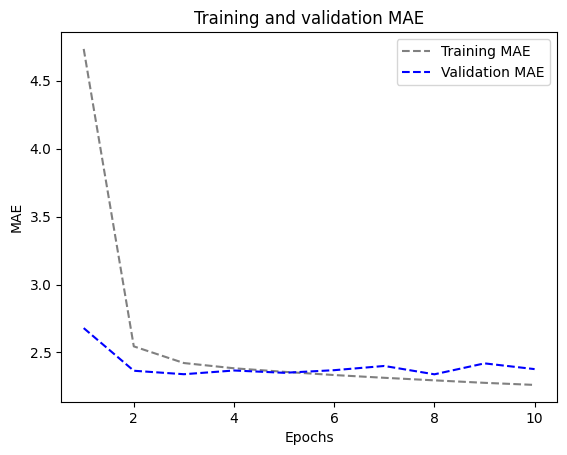

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )
1.LSTM-Simple

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 134s 157ms/step - loss: 43.1016 - mae: 4.7801 - val_loss: 12.6919 - val_mae: 2.7012
Epoch 2/10
819/819 [==============================] - 131s 160ms/step - loss: 10.9959 - mae: 2.5649 - val_loss: 9.8037 - val_mae: 2.4354
Epoch 3/10
819/819 [==============================] - 128s 156ms/step - loss: 9.9190 - mae: 2.4464 - val_loss: 9.5578 - val_mae: 2.4041
Epoch 4/10
819/819 [==============================] - 139s 170ms/step - loss: 9.5765 - mae: 2.4011 - val_loss: 9.7712 - val_mae: 2.4405
Epoch 5/10
819/819 [==============================] - 139s 170ms/step - loss: 9.2813 - mae: 2.3599 - val_loss: 9.8002 - val_mae: 2.4429
Epoch 6/10
819/819 [==============================] - 142s 173ms/step - loss: 9.1339 - mae: 2.3390 - val_loss: 9.8699 - val_mae: 2.4469
Epoch 7/10
819/819 [==============================] - 128s 156ms/step - loss: 8.8439 - mae: 2.3080 - val_loss: 10.0693 - val_mae: 2.4762
Epoch 8/10
819/819 [========================

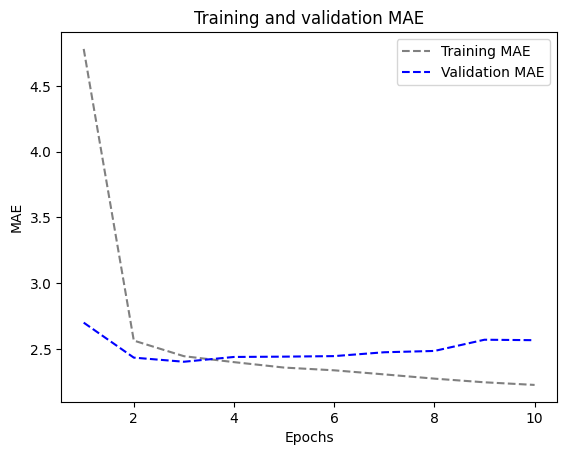

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 221s 265ms/step - loss: 45.9237 - mae: 5.0475 - val_loss: 13.1677 - val_mae: 2.7472
Epoch 2/10
819/819 [==============================] - 231s 282ms/step - loss: 20.1390 - mae: 3.4545 - val_loss: 10.0441 - val_mae: 2.4655
Epoch 3/10
819/819 [==============================] - 224s 273ms/step - loss: 18.4355 - mae: 3.3070 - val_loss: 9.5462 - val_mae: 2.4115
Epoch 4/10
819/819 [==============================] - 203s 248ms/step - loss: 17.6242 - mae: 3.2339 - val_loss: 9.5809 - val_mae: 2.4098
Epoch 5/10
819/819 [==============================] - 201s 245ms/step - loss: 16.8154 - mae: 3.1555 - val_loss: 9.1516 - val_mae: 2.3624
Epoch 6/10
819/819 [==============================] - 201s 245ms/step - loss: 16.2925 - mae: 3.1077 - val_loss: 9.3120 - val_mae: 2.3796
Epoch 7/10
819/819 [==============================] - 201s 246ms/step - loss: 15.9143 - mae: 3.0746 - val_loss: 9.2141 - val_mae: 2.3669
Epoch 8/10
819/819 [===================

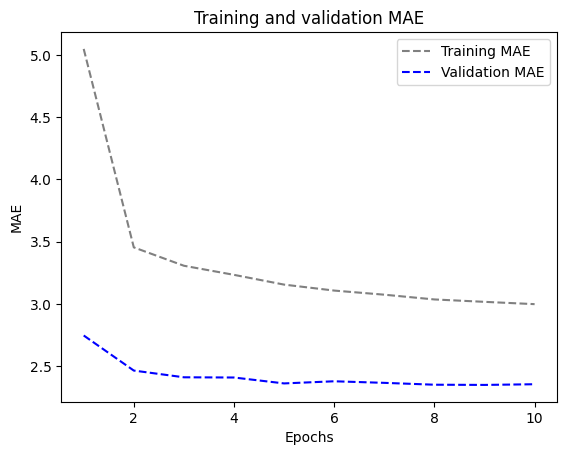

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


3.LSTM - Stacked setup with 16 units

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 218s 261ms/step - loss: 31.9225 - mae: 4.0891 - val_loss: 11.2035 - val_mae: 2.5585
Epoch 2/10
819/819 [==============================] - 211s 258ms/step - loss: 9.9749 - mae: 2.4559 - val_loss: 9.8548 - val_mae: 2.4554
Epoch 3/10
819/819 [==============================] - 212s 259ms/step - loss: 8.6959 - mae: 2.2998 - val_loss: 9.7248 - val_mae: 2.4415
Epoch 4/10
819/819 [==============================] - 219s 268ms/step - loss: 8.0638 - mae: 2.2157 - val_loss: 9.7228 - val_mae: 2.4501
Epoch 5/10
819/819 [==============================] - 216s 264ms/step - loss: 7.5507 - mae: 2.1454 - val_loss: 10.2361 - val_mae: 2.5156
Epoch 6/10
819/819 [==============================] - 213s 260ms/step - loss: 7.1211 - mae: 2.0861 - val_loss: 10.7555 - val_mae: 2.5848
Epoch 7/10
819/819 [==============================] - 209s 255ms/step - loss: 6.7041 - mae: 2.0249 - val_loss: 10.5030 - val_mae: 2.5437
Epoch 8/10
819/819 [=======================

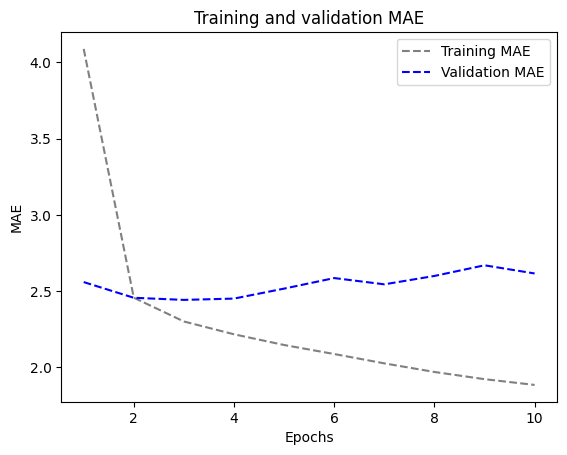

In [ ]:


 import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 32 units

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 246s 292ms/step - loss: 19.8362 - mae: 3.1991 - val_loss: 9.4450 - val_mae: 2.3816
Epoch 2/10
819/819 [==============================] - 238s 290ms/step - loss: 8.3552 - mae: 2.2473 - val_loss: 10.1394 - val_mae: 2.4988
Epoch 3/10
819/819 [==============================] - 277s 338ms/step - loss: 7.0435 - mae: 2.0555 - val_loss: 10.7580 - val_mae: 2.5568
Epoch 4/10
819/819 [==============================] - 236s 288ms/step - loss: 6.0362 - mae: 1.8942 - val_loss: 11.7584 - val_mae: 2.6935
Epoch 5/10
819/819 [==============================] - 233s 284ms/step - loss: 5.3445 - mae: 1.7734 - val_loss: 11.9697 - val_mae: 2.7099
Epoch 6/10
819/819 [==============================] - 273s 333ms/step - loss: 4.6790 - mae: 1.6546 - val_loss: 12.4879 - val_mae: 2.7631
Epoch 7/10
819/819 [==============================] - 240s 293ms/step - loss: 4.1999 - mae: 1.5594 - val_loss: 13.0546 - val_mae: 2.8206
Epoch 8/10
819/819 [=====================

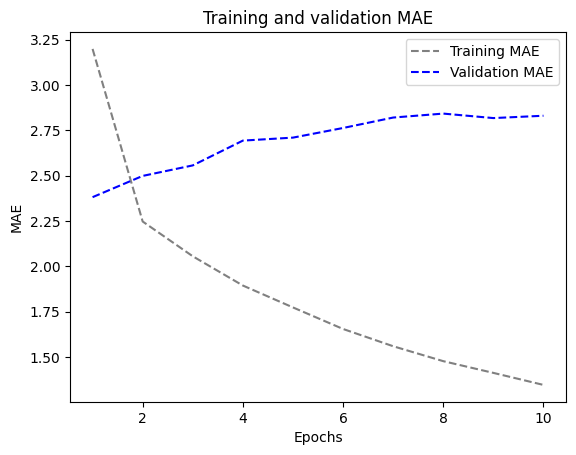

In [21]:
 import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 8 units

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 165s 191ms/step - loss: 73.7566 - mae: 6.5656 - val_loss: 37.3622 - val_mae: 4.5306
Epoch 2/2
405/405 [==============================] - 29s 70ms/step - loss: 16.9523 - mae: 3.0611
Test MAE: 3.06


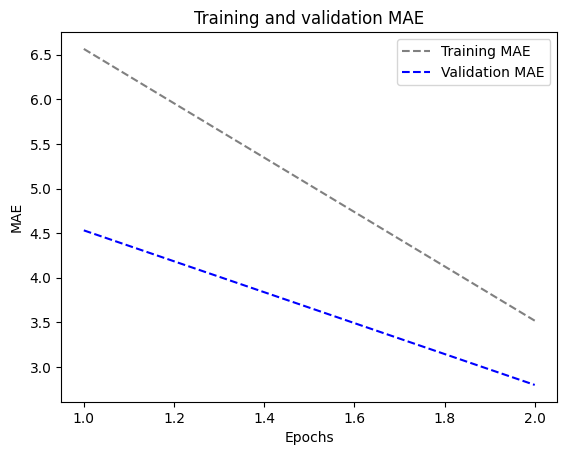

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - dropout-regularized, stacked model

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 291s 350ms/step - loss: 77.6914 - mae: 6.7731 - val_loss: 35.9337 - val_mae: 4.4504
Epoch 2/2
405/405 [==============================] - 33s 80ms/step - loss: 17.0545 - mae: 3.0375
Test MAE: 3.04


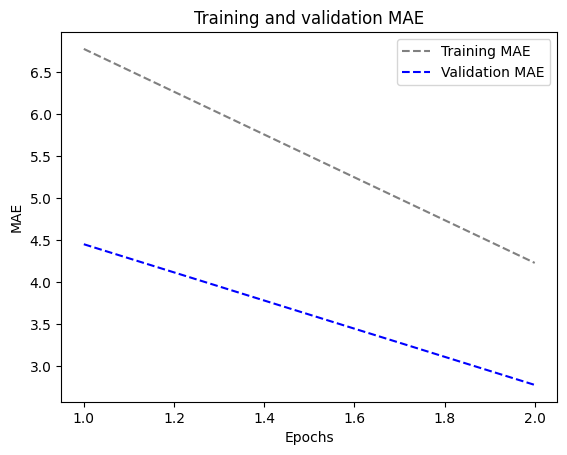

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 152s 181ms/step - loss: 25.0062 - mae: 3.5907 - val_loss: 10.7546 - val_mae: 2.5472
Epoch 2/2
405/405 [==============================] - 31s 73ms/step - loss: 10.6528 - mae: 2.5467
Test MAE: 2.55


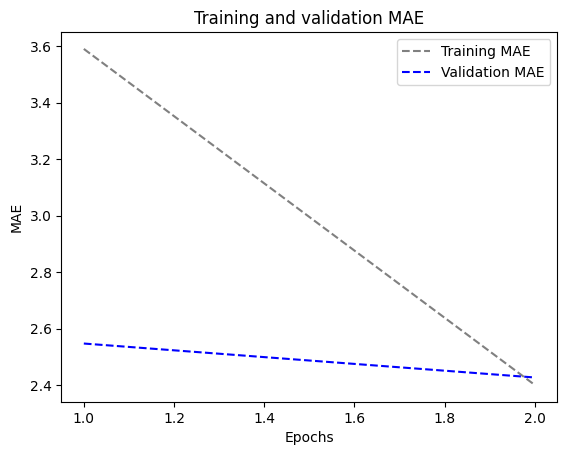

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM together

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=2, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 104s 121ms/step - loss: 47.5532 - mae: 5.1481 - val_loss: 25.2204 - val_mae: 3.9179
Epoch 2/2
405/405 [==============================] - 21s 49ms/step - loss: 24.7349 - mae: 3.8871
Test MAE: 3.89


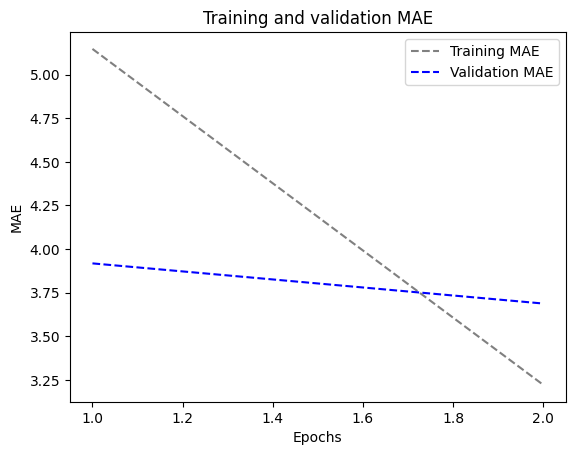

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

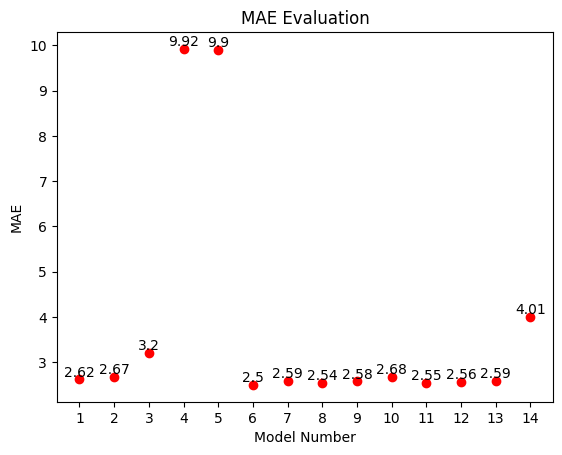

In [30]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()